In [2]:
import os

import pandas as pd
import numpy as np
import plotly.express as px

from utils.data_utils import format_policy_data

In [3]:
print(os.getcwd())

c:\Users\gsamp\Documents\AAAAAAA\TFG\covid_prediction


In [14]:
df = pd.read_pickle(r'data\training_data\training_data_v1.0.pkl')
df = df.dropna(subset=['weekly_cases', 'weekly_deaths', 'C', 'E', 'G', 'S'])
df.set_index(['location', 'date'], inplace=True)

In [15]:
def remove_leading_zeros(group):
    first_non_zero_index = group[group['weekly_cases'] != 0].index[0]  # Find the first non-zero row
    return group.loc[first_non_zero_index:]  # Keep rows from the first non-zero row onward

# Apply the function to each group
filtered_df = df.groupby('location', group_keys=False).apply(remove_leading_zeros)

# Display the result
display(filtered_df.head())

new_cases  new_deaths  total_cases  total_deaths  \
location date                                                           
Algeria  2020-03-01        1.0         0.0            1             0   
         2020-03-02        0.0         0.0            1             0   
         2020-03-03        0.0         0.0            1             0   
         2020-03-04        0.0         0.0            1             0   
         2020-03-05        0.0         0.0            1             0   

                     weekly_cases  weekly_deaths  biweekly_cases  \
location date                                                      
Algeria  2020-03-01           1.0            0.0             1.0   
         2020-03-02           1.0            0.0             1.0   
         2020-03-03           1.0            0.0             1.0   
         2020-03-04           1.0            0.0             1.0   
         2020-03-05           1.0            0.0             1.0   

                     biweekly_deaths     C    E     G     S  
location date                                                
Algeria  2020-03-01              0.0  0.00  0.0  0.00  0.00  
         2020-03-02              0.0  0.00  0.0  0.00  0.00  
         2020-03-03              0.0  0.00  0.0  0.00  0.00  
         2020-03-04              0.0  0.00  0.0  0.00  0.00  
         2020-03-05              0.0  3.57  0.0  3.12  5.56

In [16]:
# Set multi-index: country + date

# Split numerical and non-numerical (excluding target)
numerical_cols = df.select_dtypes(include='number').columns.difference(['target']).tolist()
non_numerical_cols = df.select_dtypes(exclude='number').columns.tolist()

# Aggregate per country, resampled weekly (Sunday as week-end)
weekly_numerical = df[numerical_cols].groupby('location').resample('W-SUN', level='date').mean()
weekly_categorical = df[non_numerical_cols].groupby('location').resample('W-SUN', level='date').first()
weekly_target = df[['weekly_cases']].groupby('location').resample('W-SUN', level='date').first()

# Combine all
weekly_df = pd.concat([weekly_target, weekly_numerical.drop(columns=['weekly_cases']), weekly_categorical], axis=1).reset_index()


In [17]:
weekly_df.loc[weekly_df.location == 'Spain']

,location,date,weekly_cases,C,E,G,S,biweekly_cases,biweekly_deaths,new_cases,new_deaths,total_cases,total_deaths,weekly_deaths
6084,Spain,2020-01-12,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000
6085,Spain,2020-01-19,0.0,0.000000,0.0,0.000000,0.000000,0.666667,0.000000,0.285714,0.000000,2.857143e-01,0.000000,0.000000
6086,Spain,2020-01-26,2.0,1.020000,0.0,0.891429,0.000000,2.142857,0.000000,0.142857,0.000000,2.142857e+00,0.000000,0.000000
6087,Spain,2020-02-02,1.0,8.504286,0.0,7.437143,4.761429,3.000000,0.000000,0.285714,0.000000,3.285714e+00,0.000000,0.000000
6088,Spain,2020-02-09,2.0,16.670000,0.0,14.580000,11.110000,3.142857,0.000000,0.285714,0.000000,5.285714e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6235,Spain,2022-12-04,19892.0,25.000000,0.0,21.880000,5.560000,41462.571429,340.857143,2756.285714,26.142857,1.368479e+07,118138.142857,176.142857
6236,Spain,2022-12-11,19294.0,25.000000,0.0,21.880000,5.560000,38771.285714,360.142857,2427.000000,27.142857,1.370376e+07,118322.142857,184.000000
6237,Spain,2022-12-18,16989.0,25.000000,0.0,21.880000,5.560000,36332.142857,381.285714,2805.428571,34.428571,1.372112e+07,118519.428571,197.285714
6238,Spain,2022-12-25,19638.0,25.000000,0.0,21.880000,5.560000,36629.285714,434.857143,2429.285714,31.000000,1.374039e+07,118757.000000,237.571429


In [18]:
spain_data = weekly_df[weekly_df['location'] == 'Spain']
fig = px.line(spain_data, x='date', y='weekly_cases', title='Weekly Cases Over Time in Spain', labels={'weekly_cases': 'Weekly Cases', 'date': 'Date'})
fig.show()

In [23]:
og_data = pd.read_pickle(r'data\training_data\training_data_v1.0.pkl')
og_data = og_data.groupby('location', group_keys=False).apply(remove_leading_zeros)

C:\Users\gsamp\AppData\Local\Temp\ipykernel_18620\2459691392.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [26]:
print(og_data.shape)
print(weekly_df.shape)
weekly_df.to_pickle(r'data/training_data/training_datav2_0-weekly.pkl')

(50644, 14)
(6864, 14)


# Analysis of policy data

## Imports

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np

## Loading data

In [2]:
file_path = "data/training_data/training_datav2_0-weekly.pkl"
df = pd.read_pickle(file_path)

In [ ]:
policy_data = df[['location', 'date', 'C', 'E', 'G', 'S']].dropna().copy()

## Generate policy plots

In [18]:
import os
import matplotlib.pyplot as plt

# Create a folder to save the plots
output_folder = "country_plots"
os.makedirs(output_folder, exist_ok=True)

# Get the unique countries
unique_countries = policy_data["location"].unique()

# Loop through each country and generate a plot
for country in unique_countries:
    # Filter the data for the current country
    country_data = policy_data[policy_data["location"] == country]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(country_data["date"], country_data["C"], label="C", linewidth=2)
    plt.plot(country_data["date"], country_data["E"], label="E", linewidth=2)
    plt.plot(country_data["date"], country_data["G"], label="G", linewidth=2)
    plt.plot(country_data["date"], country_data["S"], label="S", linewidth=2)
    
    # Add title and labels
    plt.title(f"{country} - Policies Over Time")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save the plot
    output_path = os.path.join(output_folder, f"{country}_policies_plot.png")
    plt.savefig(output_path)
    plt.close()

print(f"Plots saved in the folder: {output_folder}")

Plots saved in the folder: country_plots


## Get curve cases similarity

In [25]:
import os
import pandas as pd
import numpy as np

# --- Set your custom parent folder path ---
parent_folder = "results"  # ← UPDATE THIS
output_folder = os.path.join(parent_folder, "similarity_measures")
os.makedirs(output_folder, exist_ok=True)

# --- Data Preparation ---
cases_data = df[['date', 'location', 'weekly_cases']].dropna().copy()
all_countries = cases_data['location'].unique()

# --- Loop over all countries as targets ---
for target_country in all_countries:
    target_array = np.array(cases_data.loc[cases_data['location'] == target_country]['weekly_cases'])

    correlation_results = []

    for country in all_countries:
        if country == target_country:
            continue
        
        country_array = np.array(cases_data.loc[cases_data['location'] == country]['weekly_cases'])

        if len(country_array) == len(target_array):
            correlation = np.corrcoef(target_array, country_array)[0, 1]
            correlation_results.append({
                'country': country,
                'pearson_correlation': correlation
            })
        else:
            print(f"Skipped {country} compared to {target_country} due to mismatched length.")

    # Save results to CSV
    correlation_df = pd.DataFrame(correlation_results)
    output_path = os.path.join(output_folder, f"{target_country}_correlation_results.csv")
    correlation_df.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")


Saved: results\similarity_measures\Algeria_correlation_results.csv
Saved: results\similarity_measures\Argentina_correlation_results.csv
Saved: results\similarity_measures\Australia_correlation_results.csv
Saved: results\similarity_measures\Austria_correlation_results.csv
Saved: results\similarity_measures\Belgium_correlation_results.csv
Saved: results\similarity_measures\Bolivia_correlation_results.csv
Saved: results\similarity_measures\Bulgaria_correlation_results.csv
Saved: results\similarity_measures\Canada_correlation_results.csv
Saved: results\similarity_measures\Chile_correlation_results.csv
Saved: results\similarity_measures\Croatia_correlation_results.csv
Saved: results\similarity_measures\Cyprus_correlation_results.csv
Saved: results\similarity_measures\Denmark_correlation_results.csv
Saved: results\similarity_measures\Estonia_correlation_results.csv
Saved: results\similarity_measures\Finland_correlation_results.csv
Saved: results\similarity_measures\France_correlation_results

In [6]:
import os
import pandas as pd
import numpy as np

# --- Set your custom parent folder path ---
parent_folder = "results"  # ← UPDATE THIS
output_folder = os.path.join(parent_folder, "similarity_measures")
os.makedirs(output_folder, exist_ok=True)

# --- Data Preparation ---
cases_data = df[['date', 'location', 'weekly_cases']].dropna().copy()
all_countries = cases_data['location'].unique()

# --- Initialize empty DataFrame for the similarity matrix ---
similarity_matrix = pd.DataFrame(index=all_countries, columns=all_countries, dtype=float)

# --- Fill the matrix ---
for country1 in all_countries:
    array1 = np.array(cases_data.loc[cases_data['location'] == country1]['weekly_cases'])

    for country2 in all_countries:
        array2 = np.array(cases_data.loc[cases_data['location'] == country2]['weekly_cases'])

        if len(array1) == len(array2):
            correlation = np.corrcoef(array1, array2)[0, 1]
            similarity_matrix.loc[country1, country2] = correlation
        else:
            print(f"Skipped {country1} vs {country2} due to mismatched length.")

# --- Save the full matrix ---
output_path = os.path.join(output_folder, "full_similarity_matrix.csv")
similarity_matrix.to_csv(output_path)
print(f"Saved full similarity matrix to: {output_path}")


Saved full similarity matrix to: results\similarity_measures\full_similarity_matrix.csv


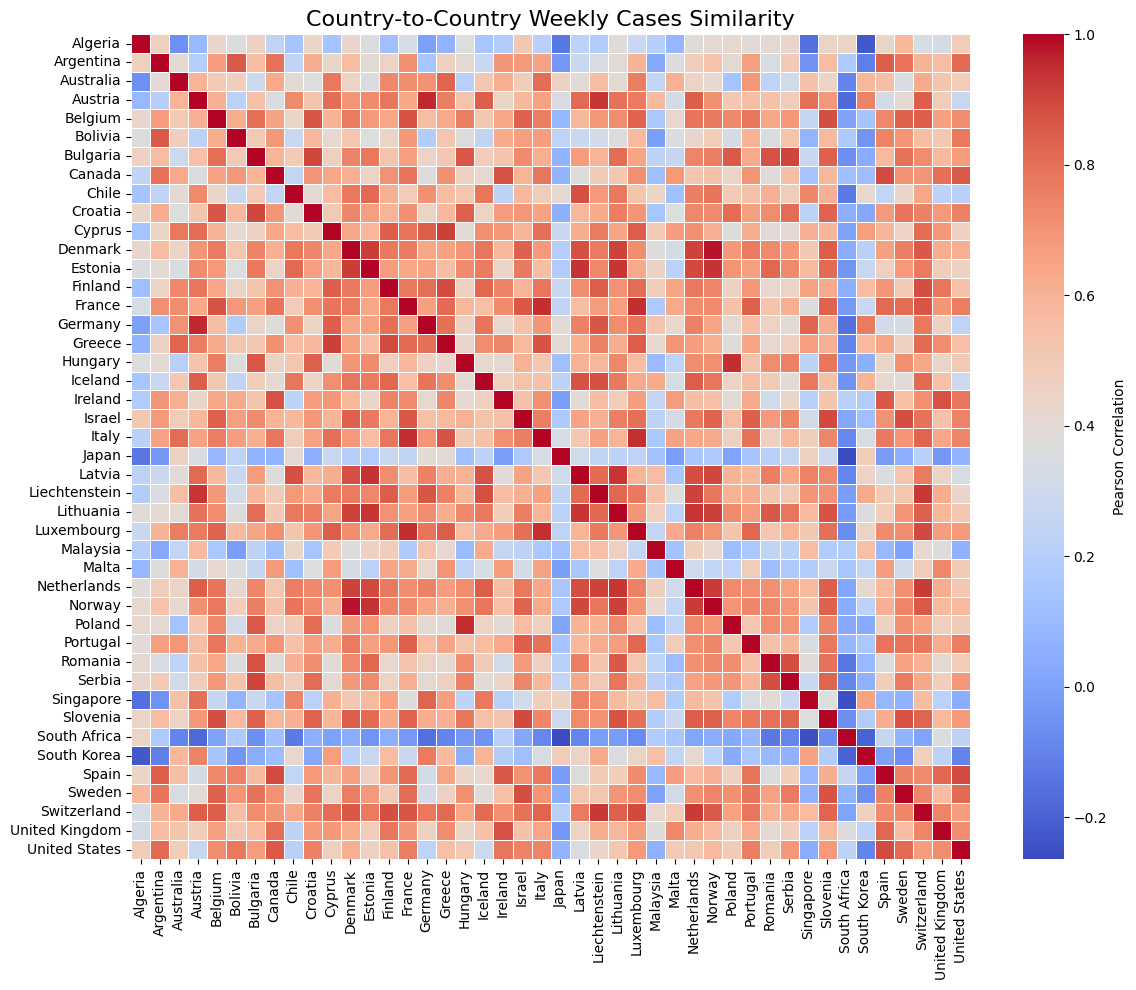

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the matrix if not already loaded
# similarity_matrix = pd.read_csv(output_path, index_col=0)

# --- Plot the heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5, cbar_kws={"label": "Pearson Correlation"})

plt.title('Country-to-Country Weekly Cases Similarity', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(output_folder, "similarity_matrix_heatmap.png"), dpi=300)
plt.show()


## EDA CHOSEN COUNTREIS

Llista de països
- South Africa
- Japan
- Belgium
- Singapore
- Sweden
- United States

In [14]:
#visualize cases data for the six countries
countries = ["South Africa", "Japan", "Belgium", "Singapore", "Sweden", "United States"]
chosen = df[['location', 'date', 'C', 'E', 'G', 'S', 'weekly_cases']].dropna().copy()
chosen = chosen[chosen['location'].isin(countries)].copy()


from sklearn.preprocessing import MinMaxScaler

# Assume your DataFrame is called df, and you want to scale 'weekly_cases'
chosen = chosen.copy()

scaler = MinMaxScaler()

# Apply scaling per country
chosen['weekly_cases_scaled'] = chosen.groupby('location')['weekly_cases'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
chosen.head()

,location,date,C,E,G,S,weekly_cases,weekly_cases_scaled
624,Belgium,2020-01-12,0.00,0.0,0.000000,0.000000,0.0,0.0
625,Belgium,2020-01-19,0.00,0.0,0.000000,0.000000,0.0,0.0
626,Belgium,2020-01-26,0.00,0.0,0.000000,0.000000,0.0,0.0
627,Belgium,2020-02-02,4.59,0.0,4.015714,7.144286,0.0,0.0
628,Belgium,2020-02-09,7.14,0.0,6.250000,11.110000,0.0,0.0


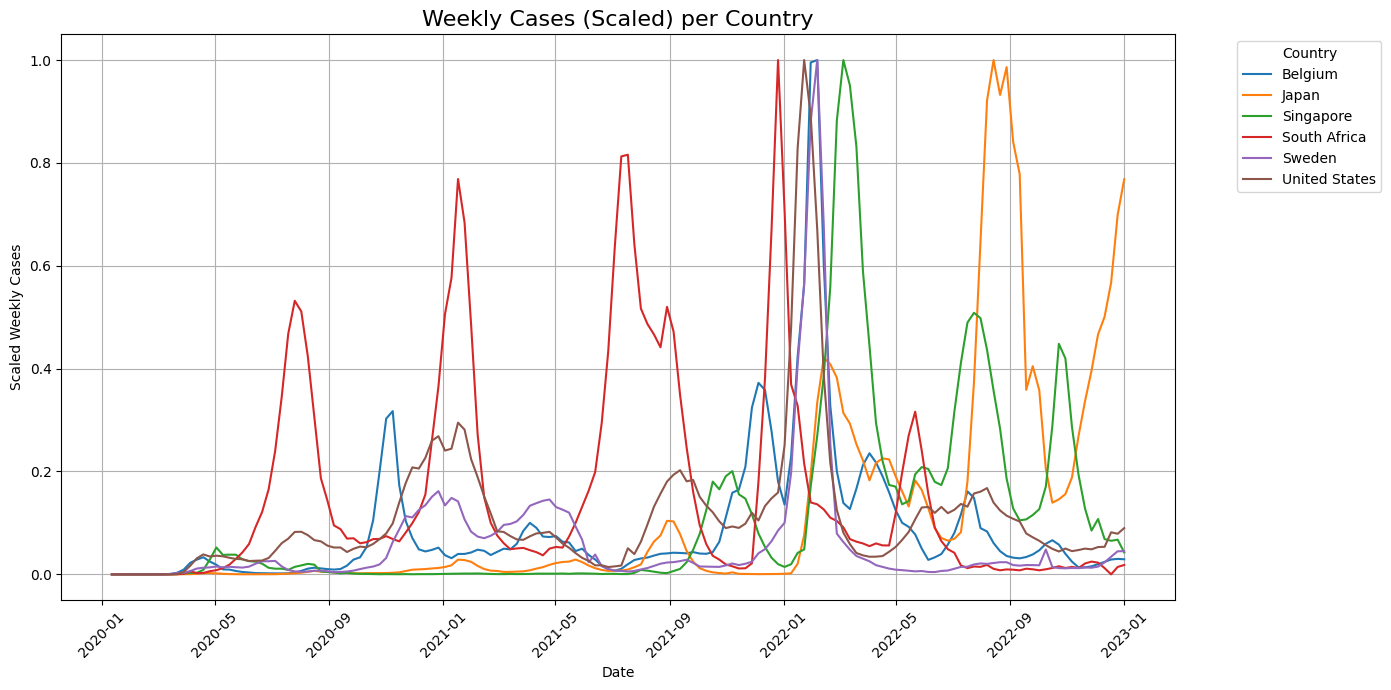

In [15]:
import matplotlib.pyplot as plt

# --- Plot ---
plt.figure(figsize=(14, 7))

for country in chosen['location'].unique():
    country_data = chosen[chosen['location'] == country]
    plt.plot(country_data['date'], country_data['weekly_cases_scaled'], label=country)

plt.title('Weekly Cases (Scaled) per Country', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Scaled Weekly Cases')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save if you want
# plt.savefig("scaled_weekly_cases_per_country.png", dpi=300)

plt.show()


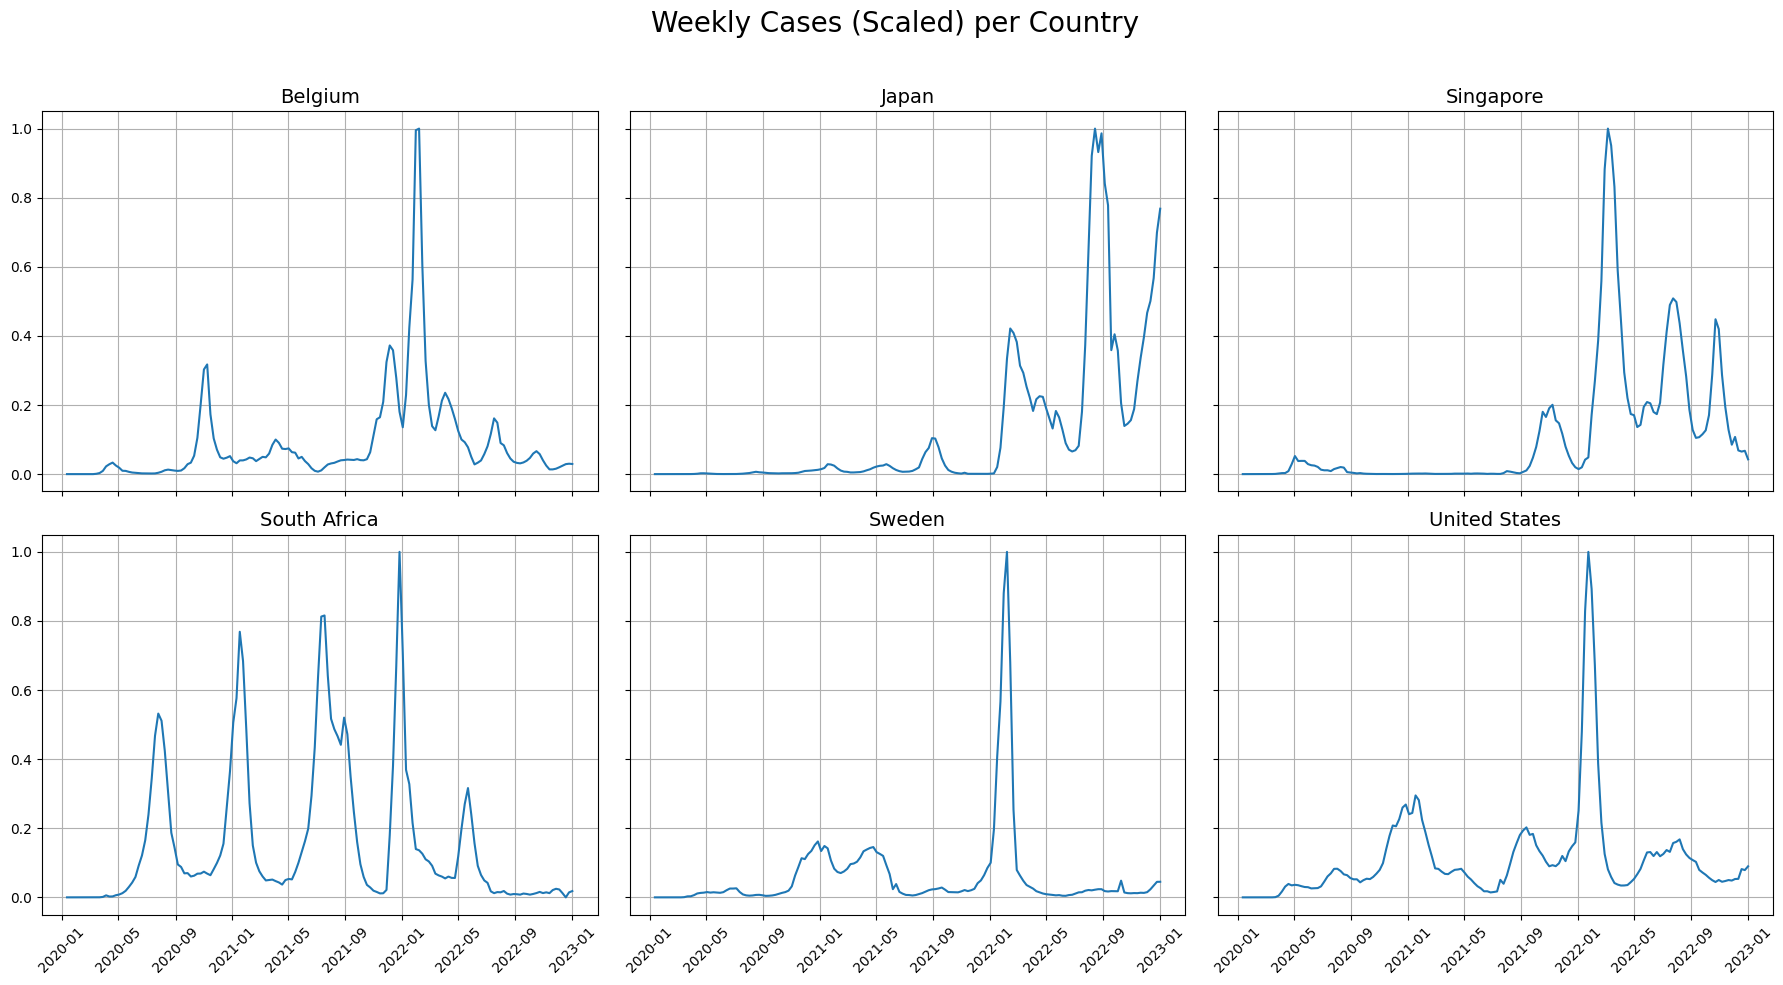

In [16]:
import matplotlib.pyplot as plt

# --- Setup subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)  
# 2 rows, 3 columns (because 6 countries)

axes = axes.flatten()  # Flatten to make it easy to loop

# --- Plot for each country ---
for idx, country in enumerate(chosen['location'].unique()):
    ax = axes[idx]
    country_data = chosen[chosen['location'] == country]
    ax.plot(country_data['date'], country_data['weekly_cases_scaled'], label=country, color='tab:blue')
    
    ax.set_title(country, fontsize=14)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# --- Global figure settings ---
fig.suptitle('Weekly Cases (Scaled) per Country', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle

# Save the figure if you want
# plt.savefig("scaled_weekly_cases_subplots.png", dpi=300)

plt.show()


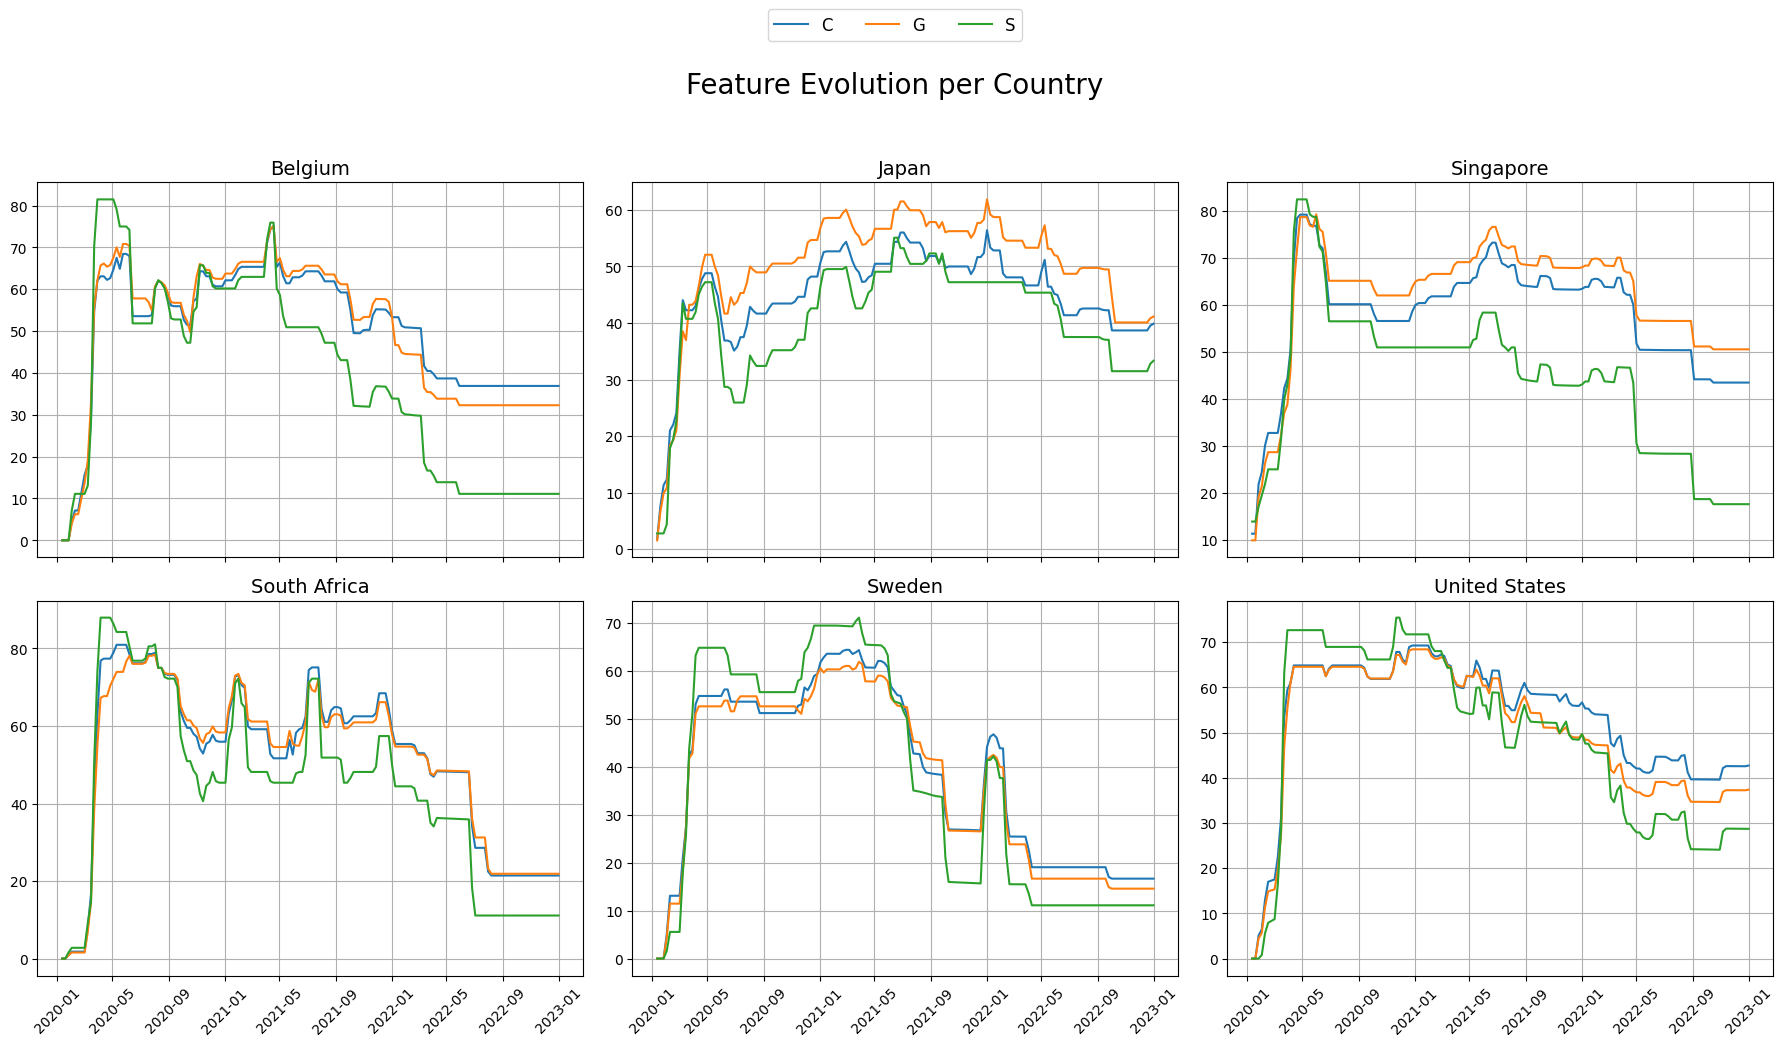

In [18]:
#visualize policy data
import matplotlib.pyplot as plt

# --- Setup subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=False)  
# 2 rows, 3 columns for 6 countries

axes = axes.flatten()  # Flatten axes to easily index them

feature_columns = ['C', 'G', 'S']

# --- Plot for each country ---
for idx, country in enumerate(chosen['location'].unique()):
    ax = axes[idx]
    country_data = chosen[chosen['location'] == country]

    for feature in feature_columns:
        ax.plot(country_data['date'], country_data[feature], label=feature)
    
    ax.set_title(country, fontsize=14)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# --- Add a single legend for all plots ---
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), fontsize=12)

# --- Global figure settings ---
fig.suptitle('Feature Evolution per Country', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle and legend

# Save if you want
# plt.savefig("features_per_country.png", dpi=300)

plt.show()


Mirant al resultat de les similarities, vull escollir 5 països amb corves de casos diferents per veure com son les seves policies i fer experiments per comprobar que haguès passat

# Modificar dades d'un païs per veure com afecta a les prediccions del model

canviar les dades de sud àfrica per les de JAPÓ a partir del segon pic de casos de Sud Àfrica que és 09 del 2020.

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np

In [8]:
file_path = "data/training_data/training_datav2_0-weekly.pkl"
df = pd.read_pickle(file_path)
# df = df[['location', 'date', 'weekly_cases', 'weekly_deaths', 'C', 'E', 'G', 'S']].dropna().copy()
df_coutnries = df.loc[df.location.isin(['South Africa', 'Japan'])].copy()


In [11]:
columns_to_change = ['date', 'C', 'E', 'G', 'S']

japan_data = df_coutnries[(df_coutnries['location'] == 'Japan') & (df_coutnries['date'] >= '2020-09-01')]
japan_data = japan_data[columns_to_change].copy()

south_africa_early = df_coutnries[(df_coutnries['location'] == 'South Africa') & (df_coutnries['date'] < '2020-09-01')]
south_africa_late = df_coutnries[(df_coutnries['location'] == 'South Africa') & (df_coutnries['date'] >= '2020-09-01')]
south_africa_late = south_africa_late[[col for col in df_coutnries.columns if col not in columns_to_change] + ['date']].copy()
south_africa_late.head()

,location,weekly_cases,biweekly_cases,biweekly_deaths,new_cases,new_deaths,total_cases,total_deaths,weekly_deaths,date
5806,South Africa,15506.0,37603.857143,2230.857143,2047.571429,114.000000,624598.571429,16581.000000,966.000000,2020-09-06
5807,South Africa,14333.0,29242.428571,1742.571429,1618.571429,92.571429,638502.571429,17357.571429,776.571429,2020-09-13
5808,South Africa,11330.0,25250.000000,1405.285714,1634.571429,73.285714,649848.571429,17986.285714,628.714286,2020-09-20
5809,South Africa,11442.0,22559.428571,1130.714286,1406.000000,62.285714,661062.000000,18488.285714,502.000000,2020-09-27
5810,South Africa,9842.0,21109.142857,956.000000,1459.714286,80.285714,670957.714286,18942.285714,454.000000,2020-10-04


In [44]:
#change all policies to 100

south_africa_mod = df_coutnries[(df_coutnries['location'] == 'South Africa') & (df_coutnries['date'] >= '2020-09-01')]
south_africa_mod.loc[:, ['C', 'E', 'G', 'S']] = 0

# merged_data = pd.merge(south_africa_late, japan_data, on='date', how='inner')
final_data = pd.concat([south_africa_early, south_africa_mod], ignore_index = True)

no_target_country = df.loc[df['location'] != 'South Africa']
df_with_mod_data = pd.concat([no_target_country, final_data], ignore_index = True)
df_with_mod_data.to_pickle(r'data\training_data\mod_data\south_africa_0.pkl')

In [43]:
df_with_mod_data.loc[df_with_mod_data.location == 'South Africa'].tail(20)

,location,date,weekly_cases,C,E,G,S,biweekly_cases,biweekly_deaths,new_cases,new_deaths,total_cases,total_deaths,weekly_deaths
6844,South Africa,2022-08-21,1293.0,0.0,0.0,0.0,0.0,3014.142857,12.000000,223.714286,12.000000,4.008388e+06,101994.000000,12.000000
6845,South Africa,2022-08-28,1566.0,0.0,0.0,0.0,0.0,2885.714286,86.571429,211.428571,2.571429,4.009941e+06,102068.571429,74.571429
6846,South Africa,2022-09-04,1480.0,0.0,0.0,0.0,0.0,3004.428571,93.428571,182.142857,3.428571,4.011392e+06,102087.428571,18.857143
6847,South Africa,2022-09-11,1275.0,0.0,0.0,0.0,0.0,2799.571429,42.428571,256.000000,3.000000,4.012741e+06,102111.000000,23.571429
6848,South Africa,2022-09-18,1792.0,0.0,0.0,0.0,0.0,3113.857143,44.000000,229.000000,2.428571,4.014506e+06,102131.428571,20.428571
6849,South Africa,2022-09-25,1603.0,0.0,0.0,0.0,0.0,3322.285714,38.285714,183.285714,3.285714,4.016063e+06,102149.285714,17.857143
6850,South Africa,2022-10-02,1283.0,0.0,0.0,0.0,0.0,2886.285714,39.857143,229.285714,2.285714,4.017392e+06,102171.285714,22.000000
6851,South Africa,2022-10-09,1605.0,0.0,0.0,0.0,0.0,2993.285714,37.000000,288.571429,1.285714,4.019057e+06,102186.285714,15.000000
6852,South Africa,2022-10-16,2020.0,0.0,0.0,0.0,0.0,3762.857143,30.142857,367.142857,7.428571,4.021155e+06,102201.428571,15.142857
6853,South Africa,2022-10-23,2570.0,0.0,0.0,0.0,0.0,4589.571429,61.285714,288.142857,1.571429,4.023646e+06,102247.571429,46.142857


In [ ]:
merged_data = pd.merge(south_africa_late, japan_data, on='date', how='inner')
final_data = pd.concat([south_africa_early, merged_data], ignore_index = True)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [32]:
no_target_country = df.loc[df['location'] != 'South Africa']
no_target_country = no_target_country.loc[no_target_country['location'] != 'Japan']
df_with_mod_data = pd.concat([no_target_country, final_data], ignore_index = True)
df_with_mod_data = df_with_mod_data.sort_values(by=['location', 'date']).reset_index(drop=True)
df_with_mod_data.to_pickle(r'data\training_data\mod_data\south_africa_with_japan.pkl')
#df_with_mod_data.to_csv(r'data\training_data\mod_data\south_africa_with_japan.csv', index=False)

# adding more features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
current_data =  pd.read_pickle("data/training_data/training_datav2_0-weekly.pkl")

In [3]:
hospital_data = pd.read_pickle('data/pickles/hospital_data.pkl')
cases_data = pd.read_pickle('data/pickles/cases_data.pkl')
vaccine_data = pd.read_pickle('data/pickles/vaccine_data.pkl')
policy_data = pd.read_pickle('data/pickles/policy_data.pkl')
policy_vaccine_data = pd.read_pickle('data/pickles/policy_vaccine_data.pkl')

## Hospital data

In [4]:
hospital_data.entity.nunique()

50

In [12]:
hospital_data.indicator.unique()
hospital_data_pivot = hospital_data.pivot_table(index=['entity', 'iso_code', 'date'], columns='indicator', values='value').reset_index()
# Keep only the columns 'entity', 'iso_code', 'date', and those containing the word 'weekly'
columns_to_keep = ['entity', 'iso_code', 'date'] + [col for col in hospital_data_pivot.columns if 'weekly' in col.lower()]
hospital_data_pivot = hospital_data_pivot[columns_to_keep]
print(hospital_data_pivot.entity.nunique())
hospital_data_pivot = hospital_data_pivot.loc[hospital_data_pivot.entity.isin(current_data.location.unique())].copy()
print(hospital_data_pivot.entity.nunique())
hospital_data_pivot['date'] = pd.to_datetime(hospital_data_pivot['date'])
print(hospital_data_pivot.entity.nunique())
hospital_data_pivot = hospital_data_pivot.dropna(subset= ['Weekly new hospital admissions'])
print(hospital_data_pivot.entity.nunique())

50
44
44
29


In [10]:
hospital_data_pivot.columns

Index(['entity', 'iso_code', 'date', 'Weekly new ICU admissions',
       'Weekly new ICU admissions per million',
       'Weekly new hospital admissions',
       'Weekly new hospital admissions per million'],
      dtype='object', name='indicator')

In [ ]:
# Filter hospital_data_pivot to match the date range of each country in current_data
filtered_hospital_data = pd.DataFrame()

for country in current_data['location'].unique():
    # Get the date range for the current country in current_data
    country_dates = current_data[current_data['location'] == country]['date']
    start_date, end_date = country_dates.min(), country_dates.max()
    
    # Filter hospital_data_pivot for the current country and date range
    country_hospital_data = hospital_data_pivot[
        (hospital_data_pivot['entity'] == country) &
        (hospital_data_pivot['date'] >= start_date) &
        (hospital_data_pivot['date'] <= end_date)
    ]
    
    # Append the filtered data to the result
    filtered_hospital_data = pd.concat([filtered_hospital_data, country_hospital_data], ignore_index=True)

# Ensure the 'date' column is in datetime format
filtered_hospital_data['date'] = pd.to_datetime(filtered_hospital_data['date'])

## BOOKMARK1

# Set the 'date' column as the index
filtered_hospital_data.set_index('date', inplace=True)



# Define a function to resample data for each country
def resample_country_data(group):
    # Separate numerical and categorical columns
    numerical_cols = group.select_dtypes(include=['number']).columns
    categorical_cols = ['entity', 'iso_code']  # Add your categorical columns here

    # Resample numerical columns (average for the week)
    weekly_numerical = group[numerical_cols].resample('W-SUN').mean()

    # Resample categorical columns (e.g., take the first value of the week)
    weekly_categorical = group[categorical_cols].resample('W-SUN').first()

    # Combine numerical and categorical data
    weekly_data = pd.concat([weekly_numerical, weekly_categorical], axis=1)
    return weekly_data

# Group by 'entity' (or 'location') and apply the resampling function
weekly_hospital_data = filtered_hospital_data.groupby('entity', group_keys=False).apply(resample_country_data)

# Reset the index to make 'date' a column again
weekly_hospital_data.reset_index(inplace=True)
# Save the processed weekly hospital data as a pickle file
output_path = r'data\timeseries_pickles\additional_features\weekly_hospital_data.pkl'
weekly_hospital_data.to_pickle(output_path)

C:\Users\gsamp\AppData\Local\Temp\ipykernel_12884\1640004547.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_hospital_data = filtered_hospital_data.groupby('entity', group_keys=False).apply(resample_country_data)


## Vaccine data

In [2]:
# vaccine_data
# policy_data
# policy_vaccine_data
import pandas as pd
import pickle as pkl
vaccine_data = pd.read_pickle('data/pickles/policy_vaccine_data.pkl')
vaccine_data.head()

,CountryName,CountryCode,Jurisdiction,Date,V1_Vaccine Prioritisation (summary),V1_0-4 yrs infants,V1_5-15 yrs young people,V1_Airport/Border/Airline Staff,V1_At Risk 16-19 yrs,V1_At Risk 20-24 yrs,...,V4_People living with a vulnerable/shielding person or other priority group,V4_Police/ first responders,V4_Pregnant people,V4_Primary and secondary school students,V4_Refugees/migrants,V4_Religious/Spiritual Leaders,V4_Residents in an elderly care home,V4_Staff working in an elderly care home,V4_Tertiary education students,V4_Notes
0,Aruba,ABW,NAT_TOTAL,20200101,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,ABW,NAT_TOTAL,20200102,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,ABW,NAT_TOTAL,20200103,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,ABW,NAT_TOTAL,20200104,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,ABW,NAT_TOTAL,20200105,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
feats_to_keep = [
    'total_vaccinations_per_hundred',
    'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred',
    'total_boosters_per_hundred',
    'daily_vaccinations_per_million'
]
vaccine_data_clean = vaccine_data.dropna(subset=feats_to_keep).copy()

vaccine_data_clean = vaccine_data_clean.loc[vaccine_data_clean['location'].isin(current_data.location.unique())].copy()
vaccine_data_clean['date'] = pd.to_datetime(vaccine_data_clean['date'])
vaccine_data_clean = vaccine_data_clean.drop(columns=[col for col in 
                                                      vaccine_data_clean.columns 
                                                      if col not in 
                                                      feats_to_keep + ['location', 'date']])

In [100]:
# Filter vaccine_data_clean to match the date range of each country in current_data
filtered_vaccine_data = pd.DataFrame()

for country in current_data['location'].unique():
    # Get the date range for the current country in current_data
    country_dates = current_data[current_data['location'] == country]['date']
    start_date, end_date = country_dates.min(), country_dates.max()
    
    # Filter vaccine_data_clean for the current country and date range
    country_vaccine_data = vaccine_data_clean[
        (vaccine_data_clean['location'] == country) &
        (vaccine_data_clean['date'] >= start_date) &
        (vaccine_data_clean['date'] <= end_date)
    ]
    
    # Append the filtered data to the result
    filtered_vaccine_data = pd.concat([filtered_vaccine_data, country_vaccine_data], ignore_index=True)

# Ensure the 'date' column is in datetime format
filtered_vaccine_data['date'] = pd.to_datetime(filtered_vaccine_data['date'])

# Set the 'date' column as the index
filtered_vaccine_data.set_index('date', inplace=True)

# Define a function to resample data for each country
def resample_country_data(group):
    # Separate numerical and categorical columns
    numerical_cols = group.select_dtypes(include=['number']).columns
    categorical_cols = ['location']  # Add your categorical columns here

    # Resample numerical columns (average for the week)
    weekly_numerical = group[numerical_cols].resample('W-SUN').mean()

    # Resample categorical columns (e.g., take the first value of the week)
    weekly_categorical = group[categorical_cols].resample('W-SUN').first()

    # Combine numerical and categorical data
    weekly_data = pd.concat([weekly_numerical, weekly_categorical], axis=1)
    return weekly_data

# Group by 'entity' (or 'location') and apply the resampling function
weekly_vaccine_data = filtered_vaccine_data.groupby('location', group_keys=False).apply(resample_country_data)

# Reset the index to make 'date' a column again
weekly_vaccine_data.reset_index(inplace=True)
# Save the processed weekly hospital data as a pickle file
# output_path = r'data\timeseries_pickles\additional_features\weekly_vaccine_data.pkl'
# weekly_vaccine_data.to_pickle(output_path)

C:\Users\gsamp\AppData\Local\Temp\ipykernel_12884\497721007.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_vaccine_data = filtered_vaccine_data.groupby('location', group_keys=False).apply(resample_country_data)


In [101]:
temp = weekly_vaccine_data.dropna(subset=['location'])
temp = temp.dropna(subset=['daily_vaccinations_per_million']).copy()
list1 = temp.location.unique()
list2 = current_data.location.unique()

set1 = set(list1)
set2 = set(list2)

unique_from_list1 = set1 - set2
unique_from_list2 = set2 - set1

print("Unique elements from list1:", unique_from_list1)
print("Unique elements from list2:", unique_from_list2)

Unique elements from list1: set()
Unique elements from list2: {'Malta', 'Switzerland', 'Romania', 'Croatia', 'Liechtenstein', 'Bulgaria'}


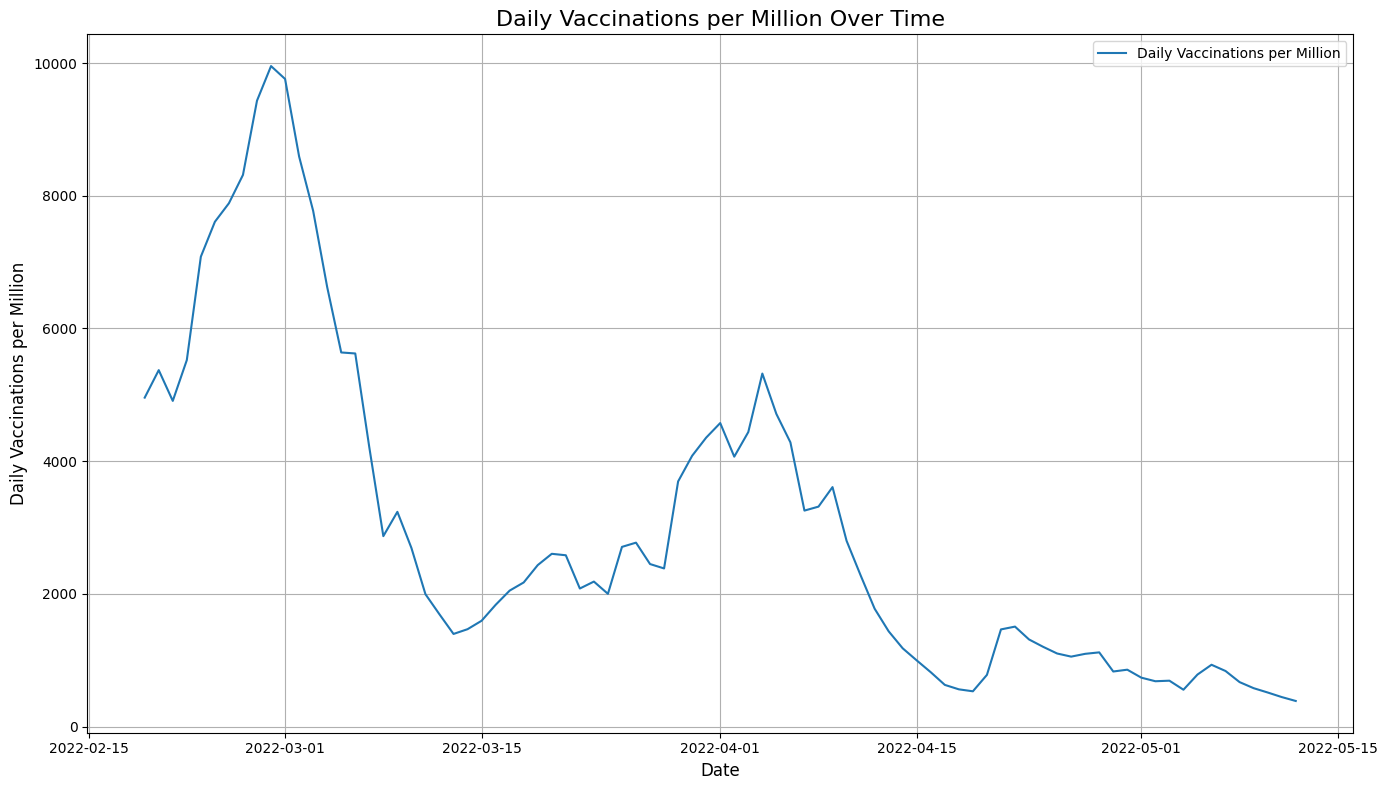

In [113]:
import matplotlib.pyplot as plt

# Ensure the 'date' column is in datetime format
vaccine_data_temp = weekly_vaccine_data.dropna().copy()
vaccine_data_temp['date'] = pd.to_datetime(vaccine_data['date'])
vaccine_data_temp = vaccine_data_temp.loc[vaccine_data_temp.location == "United States"].copy()
# Filter the DataFrame to include only the 'date' and 'daily_vaccinations_per_million' columns
daily_vaccinations_data = vaccine_data_temp[['date', 'daily_vaccinations_per_million']].dropna()

# Create the plot
plt.figure(figsize=(14, 8))
plt.plot(daily_vaccinations_data['date'], daily_vaccinations_data['daily_vaccinations_per_million'], label='Daily Vaccinations per Million', color='tab:blue')

# Add title and labels
plt.title('Daily Vaccinations per Million Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Vaccinations per Million', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

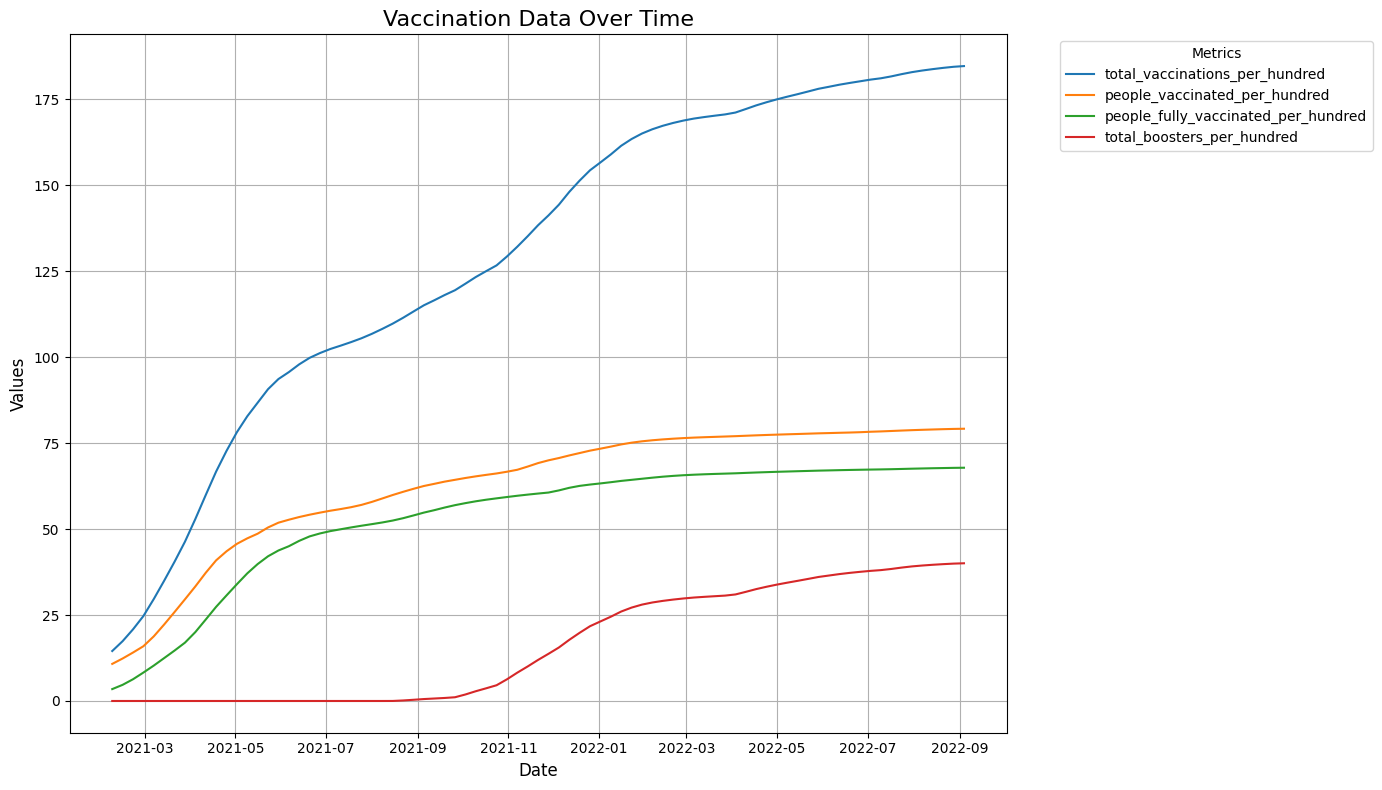

In [114]:
import matplotlib.pyplot as plt

# Ensure the 'date' column is in datetime format
vaccine_data_temp = weekly_vaccine_data.dropna().copy()
vaccine_data_temp = vaccine_data_temp.loc[vaccine_data_temp.location == "United States"].copy()
vaccine_data_temp['date'] = pd.to_datetime(vaccine_data_temp['date'])

# Define the columns to plot
columns_to_plot = [
    'total_vaccinations_per_hundred',
    'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred',
    'total_boosters_per_hundred'
]

# Filter the DataFrame to include only the columns to plot
vaccine_data_filtered = vaccine_data_temp[['date'] + columns_to_plot].dropna()

# Create the plot
plt.figure(figsize=(14, 8))

for column in columns_to_plot:
    plt.plot(vaccine_data_filtered['date'], vaccine_data_filtered[column], label=column)

# Add title and labels
plt.title('Vaccination Data Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Crec que les úniques features interessant aquí seran la daily_vaccinations_per_million i la total_vaccinations_per_hundred

In [115]:
vaccine_feats = weekly_vaccine_data[['location', 'date', 'daily_vaccinations_per_million', 'total_vaccinations_per_hundred']].copy()
vaccine_feats = vaccine_feats.dropna().copy()
vaccine_feats['date'] = pd.to_datetime(vaccine_feats['date'])
output_path = r'data\timeseries_pickles\additional_features\weekly_vaccine_feats.pkl'
vaccine_feats.to_pickle(output_path)

## visualizations

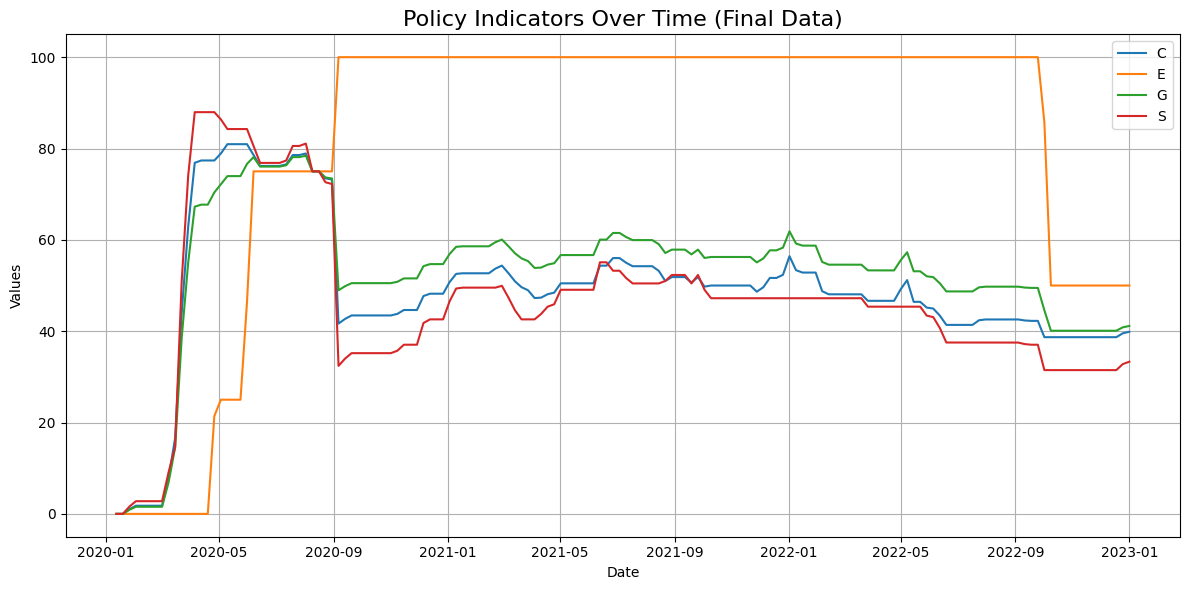

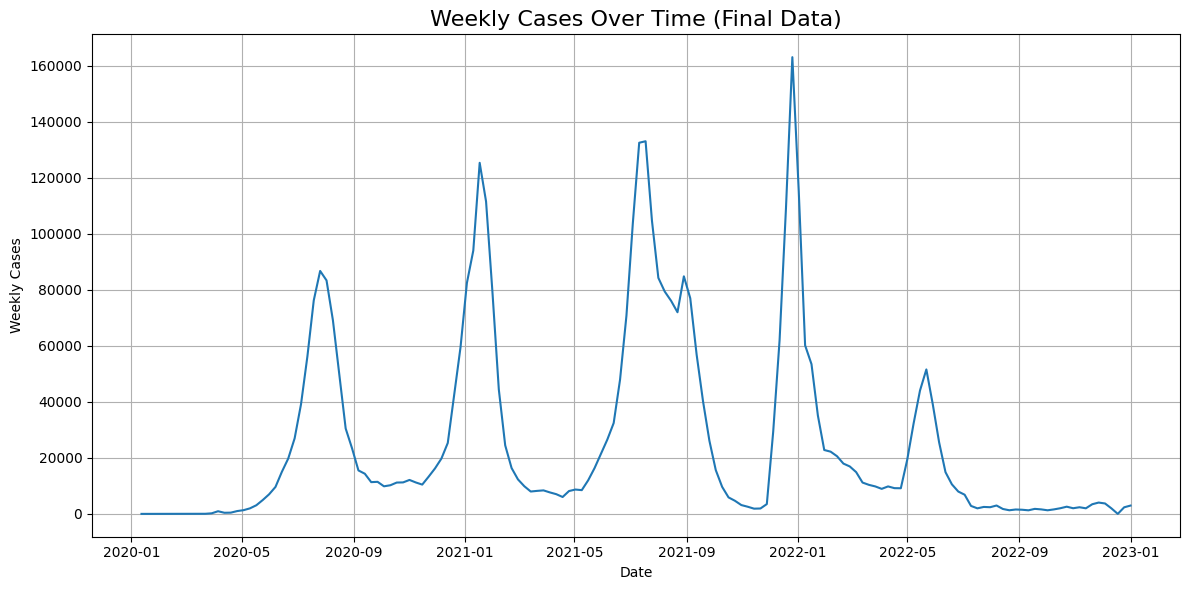

In [6]:
import matplotlib.pyplot as plt

# Plot for columns C, E, G, and S
plt.figure(figsize=(12, 6))
for col in ['C', 'E', 'G', 'S']:
    plt.plot(final_data['date'], final_data[col], label=col)
plt.title('Policy Indicators Over Time (Final Data)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Separate plot for weekly_cases
plt.figure(figsize=(12, 6))
plt.plot(final_data['date'], final_data['weekly_cases'], label='Weekly Cases', color='tab:blue')
plt.title('Weekly Cases Over Time (Final Data)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Weekly Cases')
plt.grid(True)
plt.tight_layout()
plt.show()

# No aggregation on data.

## Read and write

Aquí el que s'ha fet és llegir els sheets de policies i guardar-los com a pickles individuals, el següent pas és adaptar aquestes dades perquè es puguin fer servir per els models.

In [ ]:
import pandas as pd
reading_data_and_saving=False
if reading_data_and_saving:
    xlsx_path = r'C:\Users\gsamp\Documents\AAAAAAA\TFG\dades\OxCGRT_timeseries_all.xlsx'  # Replace with your file path
    sheet_names = pd.ExcelFile(xlsx_path).sheet_names
    print(sheet_names)

    sheets_to_read = ['c1m_school_closing', 'c2m_workplace_closing', 'c3m_cancel_public_events'
                    ,'c4m_restrictions_on_gatherings', 'c5m_close_public_transport',
                    'c6m_stay_at_home_requirements', 'c7m_movementrestrictions',
                    'c8ev_internationaltravel', 'e1_income_support', 'e2_debtrelief',
                    'h1_public_information_campaigns', 'h2_testing_policy',
                    'h3_contact_tracing', 'h6m_facial_coverings', 'h7_vaccination_policy',
                    'h8m_protection_of_elderly_ppl']
    dfs = {}
    with pd.ExcelFile(xlsx_path) as xls:
        for sheet in sheets_to_read:
            if sheet in sheet_names:
                dfs[sheet] = pd.read_excel(xls, sheet_name=sheet)
                

    print(len(sheets_to_read))
    print(len(dfs))
    set(sheets_to_read) - set(dfs.keys())
    output_dir = r"data\all_policies"
    import os
    os.makedirs(output_dir, exist_ok=True)

    for name, df in dfs.items():
        output_path = os.path.join(output_dir, f"{name}.pkl")
        df.to_pickle(output_path)

['stringency_index_avg', 'containment_health_index_avg', 'government_response_index_avg', 'economic_support_index', 'c1m_school_closing', 'c1m_flag', 'c2m_workplace_closing', 'c2m_flag', 'c3m_cancel_public_events', 'c3m_flag', 'c4m_restrictions_on_gatherings', 'c4m_flag', 'c5m_close_public_transport', 'c5m_flag', 'c6m_stay_at_home_requirements', 'c6m_flag', 'c7m_movementrestrictions', 'c7m_flag', 'c8ev_internationaltravel', 'e1_income_support', 'e1_flag', 'e2_debtrelief', 'h1_public_information_campaigns', 'h1_flag', 'h2_testing_policy', 'h3_contact_tracing', 'h6m_facial_coverings', 'h6m_flag', 'h7_vaccination_policy', 'h7_flag', 'h8m_protection_of_elderly_ppl', 'h8m_flag', 'confirmed_cases', 'confirmed_deaths']


## Data engineering

Aquí el que tinc son pickles amb el format que volem, falta ara agregar les dades per setmanes.

In [6]:
from utils.data_utils import format_policy_data
import pandas as pd
import os

In [23]:
c1m_school_closing = pd.read_pickle(r'data\all_policies\raw\c1m_school_closing.pkl')
id_vars = ['country_code', 'country_name', 'region_code', 'region_name', 'jurisdiction']
temp = format_policy_data(c1m_school_closing, id_vars=id_vars, sort_by='country_name')
temp.head()
all_pickles_dir_raw = 'data/all_policies/raw/'
for f in os.listdir(all_pickles_dir_raw):
    temp = pd.read_pickle(os.path.join(all_pickles_dir_raw, f))
    temp = format_policy_data(c1m_school_closing, id_vars=id_vars, sort_by='country_name')
    temp = temp.loc[temp.jurisdiction == 'NAT_TOTAL'].copy()
    temp.to_pickle('data/all_policies/formatted/formatted_' + f)
temp.head()

,country_code,country_name,region_code,region_name,jurisdiction,Date,Value
1,AFG,Afghanistan,NaN,NaN,NAT_TOTAL,2020-01-01,0.0
264,AFG,Afghanistan,NaN,NaN,NAT_TOTAL,2020-01-02,0.0
527,AFG,Afghanistan,NaN,NaN,NAT_TOTAL,2020-01-03,0.0
790,AFG,Afghanistan,NaN,NaN,NAT_TOTAL,2020-01-04,0.0
1053,AFG,Afghanistan,NaN,NaN,NAT_TOTAL,2020-01-05,0.0


## Adapt data for training

In [1]:
import pandas as pd
import os

In [2]:
training = pd.read_pickle(r'data\training_data\training_datav2_0-weekly.pkl')

#get dates info
dates = training.date.unique()
min_date = dates.min()
max_date = dates.max()
print("Min date:", min_date)
print("Max date:", max_date)

#get countries info
training_countries = training.location.unique()
print("Countries in training data:", len(training_countries))

Min date: 2020-01-12 00:00:00
Max date: 2023-01-01 00:00:00
Countries in training data: 44


In [3]:
# Define a function to resample data for each country
def resample_country_data_2(group):
    # Separate numerical and categorical columns
    numerical_cols = 'Value'
    categorical_cols = ['country_name']  # Add your categorical columns here

    # Resample numerical columns (average for the week)
    weekly_numerical = group[numerical_cols].resample('W-SUN').mean()

    # Resample categorical columns (e.g., take the first value of the week)
    weekly_categorical = group[categorical_cols].resample('W-SUN').first()

    # Combine numerical and categorical data
    weekly_data = pd.concat([weekly_numerical, weekly_categorical], axis=1)
    return weekly_data

In [5]:
files_dir = 'data/all_policies/formatted/'

for f in os.listdir(files_dir):
    temp_norm = pd.read_pickle(os.path.join(files_dir, f))

# #clean countries from policy features
# temp_norm = temp.copy()

    # Standardize country names: lowercase and strip spaces for comparison
    normalized_training_countries = [c.lower().strip() for c in training_countries]
    temp_norm['country_name_normalized'] = temp_norm['country_name'].str.lower().str.strip()
    temp_norm = temp_norm.loc[temp_norm.country_name.isin(training_countries)].copy()

    #standarize dates
    temp_norm = temp_norm[(temp_norm['Date'] >= min_date) & (temp_norm['Date'] <= max_date)].copy()
    # temp_spain = temp_norm.loc[temp_norm.country_name == 'Spain'].copy()
    temp_norm.set_index('Date', inplace=True)

    # Group by 'entity' (or 'location') and apply the resampling function
    temp_norm_reduced = temp_norm.groupby('country_name', group_keys=False).apply(resample_country_data_2)

    # Reset the index to make 'date' a column again
    temp_norm_reduced.reset_index(inplace=True)
    
    temp_norm_reduced.to_pickle('data\\all_policies\\training\\training_' + f)
    

C:\Users\gsamp\AppData\Local\Temp\ipykernel_23884\2691662010.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_norm_reduced = temp_norm.groupby('country_name', group_keys=False).apply(resample_country_data_2)
C:\Users\gsamp\AppData\Local\Temp\ipykernel_23884\2691662010.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_norm_reduced = temp_norm.groupby('country_name', group_keys=False).apply(r

## integrate everything in a single df

In [1]:
import pandas as pd
import os

training = pd.read_pickle(r'data\training_data\training_datav2_0-weekly.pkl')

In [29]:
dates_needed = training.date.unique()

folder = r'data\all_policies\training'
# all_files = [f for f in os.listdir(folder) if f.endswith('.pkl')]

# big_df = pd.DataFrame({'Date': sorted(list(dates_needed))})
# big_df['Date'] = pd.to_datetime(big_df['Date'])
# big_df.set_index('Date', inplace=True)
big_df = training[['location', 'date']]

for f in os.listdir(folder):
    # Extract column name: between 'training_formatted_' and next '_'
    base = os.path.basename(f)
    try:
        col_name = base.split('training_formatted_')[1].split('_')[0]
    except IndexError:
        continue  # skip files not matching pattern

    df = pd.read_pickle(os.path.join(folder, f))
    df['Date'] = pd.to_datetime(df['Date'])
    if not set(df['Date']) == set(dates_needed):
        raise ValueError(f"Date mismatch in file {f}: df dates {sorted(df['Date'].unique())} vs needed {sorted(dates_needed)}")
    filtered = df[df['Date'].isin(dates_needed)][['Date', 'Value', 'country_name']].copy()
    filtered.set_index('Date', inplace=True)
    filtered[col_name] = filtered['Value']
    # filtered.rename(columns={'Value': col_name}, inplace=True)

    
    big_df = pd.merge(big_df, filtered, how='left', 
                         left_on=['date', 'location'], right_on=['Date', 'country_name'])
    big_df.drop(columns=['Value', 'country_name'], inplace=True)

# Now big_df has one column per policy, indexed by Date

In [31]:
big_df.to_pickle(r'data\all_policies\policies_individual_final.pkl')

## visualizations

C:\Users\gsamp\AppData\Local\Temp\ipykernel_4316\3137395738.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  c = c.loc[c.country_name == 'Spain'].copy().fillna(0)
C:\Users\gsamp\AppData\Local\Temp\ipykernel_4316\3137395738.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  e = e.loc[e.country_name == 'Spain'].copy().fillna(0)


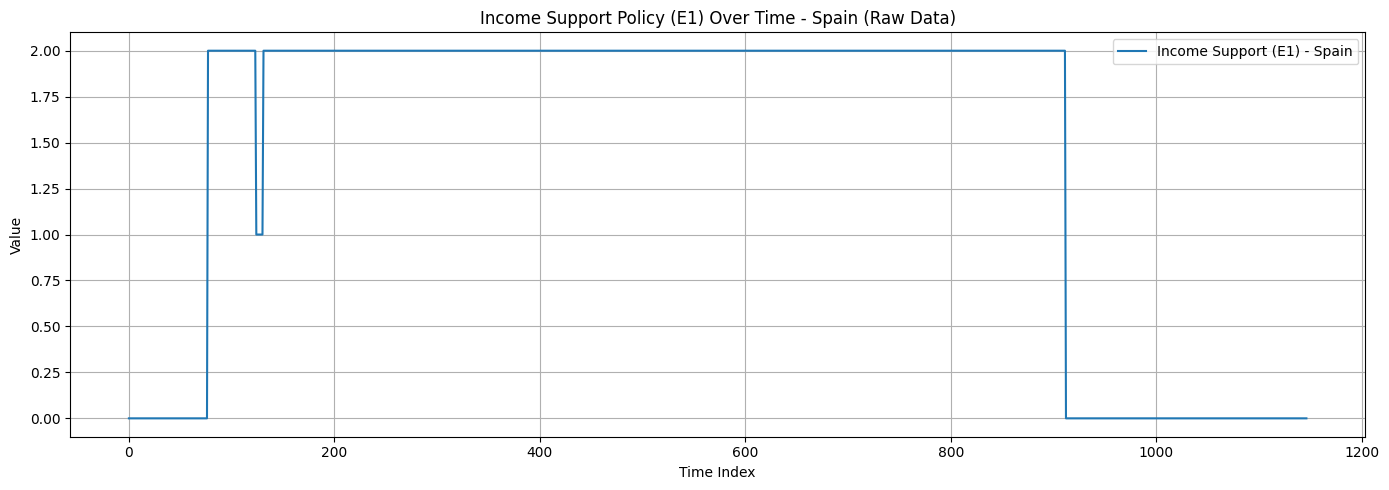

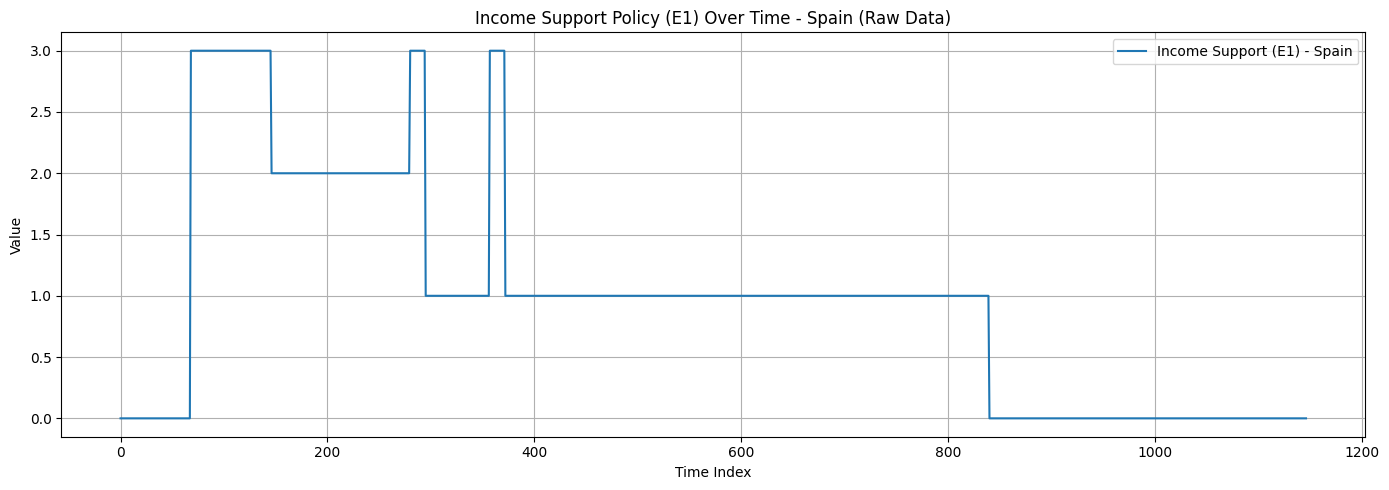

In [66]:
c = pd.read_pickle(r'data\all_policies\raw\c1m_school_closing.pkl')
e = pd.read_pickle(r'data\all_policies\raw\e1_income_support.pkl')

c = c.loc[c.country_name == 'Spain'].copy().fillna(0)
e = e.loc[e.country_name == 'Spain'].copy().fillna(0)
import matplotlib.pyplot as plt

# Select only the numerical columns (skip the first 5 metadata columns)
numerical_values = e.values[0][5:]
numerical_values


plt.figure(figsize=(14, 5))
plt.plot(numerical_values, label='Income Support (E1) - Spain')
plt.title('Income Support Policy (E1) Over Time - Spain (Raw Data)')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

numerical_values = c.values[0][5:]

plt.figure(figsize=(14, 5))
plt.plot(numerical_values, label='Income Support (E1) - Spain')
plt.title('Income Support Policy (E1) Over Time - Spain (Raw Data)')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# v2 no aggregation on data

In [52]:
import pandas as pd
import os

training = pd.read_pickle(r'data\training_data\training_datav2_0-weekly.pkl')
locations = training.location.unique()
dates = training.date.unique()

In [56]:
dir_path = r'data\all_policies\raw'
for f in os.listdir(dir_path):
    file_path = os.path.join(dir_path, f)
    print(file_path)

data\all_policies\raw\c1m_school_closing.pkl
data\all_policies\raw\c2m_workplace_closing.pkl
data\all_policies\raw\c3m_cancel_public_events.pkl
data\all_policies\raw\c4m_restrictions_on_gatherings.pkl
data\all_policies\raw\c5m_close_public_transport.pkl
data\all_policies\raw\c6m_stay_at_home_requirements.pkl
data\all_policies\raw\c7m_movementrestrictions.pkl
data\all_policies\raw\c8ev_internationaltravel.pkl
data\all_policies\raw\e1_income_support.pkl
data\all_policies\raw\e2_debtrelief.pkl
data\all_policies\raw\h1_public_information_campaigns.pkl
data\all_policies\raw\h2_testing_policy.pkl
data\all_policies\raw\h3_contact_tracing.pkl
data\all_policies\raw\h6m_facial_coverings.pkl
data\all_policies\raw\h7_vaccination_policy.pkl
data\all_policies\raw\h8m_protection_of_elderly_ppl.pkl


In [68]:
dir_path = r'data\all_policies\raw'
big_df = training[['location', 'date']].copy()
big_df['date'] = pd.to_datetime(big_df['date'])

for f in os.listdir(dir_path):

    file_path = os.path.join(dir_path, f)
    temp = pd.read_pickle(file_path)
    temp = temp.loc[temp.country_name.isin(training.location.unique())].copy().fillna(0)
    temp = temp.loc[temp.jurisdiction == 'NAT_TOTAL'].copy()
    # Convert temp.columns[5:] to datetime format for comparison
    all_dates = pd.to_datetime(temp.columns[5:], format='%d%b%Y', errors='coerce')
    all_dates = list(set(all_dates) & set(dates))

    # Keep only the columns in all_dates (convert Timestamps back to the original string format)
    date_strs = [d.strftime('%d%b%Y') for d in all_dates]
    cols_to_keep = [temp.columns[1]] + date_strs

    temp = temp[cols_to_keep]

    # Create a mapping from old date string format to new YYYY-MM-DD format
    date_col_map = {d.strftime('%d%b%Y'): d.strftime('%Y-%m-%d') for d in all_dates}
    # Rename columns using the mapping
    temp.rename(columns=date_col_map, inplace=True)


    column_value_name = file_path.split('\\')[-1].split('_')[0] 
    df_long = pd.melt(
        temp,
        id_vars=['country_name'],
        var_name='Date',
        value_name=column_value_name
    )
    df_long.rename(columns={'country_name': 'location', 'Date': 'date'}, inplace=True)
    df_long.sort_values(by=['location', 'date'], inplace=True)
    df_long['date'] = pd.to_datetime(df_long['date'])

    big_df = pd.merge(big_df, df_long, how='left', on=['location', 'date'])

big_df.head()

,location,date,c1m,c2m,c3m,c4m,c5m,c6m,c7m,c8ev,e1,e2,h1,h2,h3,h6m,h7,h8m
0,Algeria,2020-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Algeria,2020-01-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Algeria,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Algeria,2020-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Algeria,2020-02-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
big_df.to_pickle(r'data\all_policies\policies_individual_final.pkl')

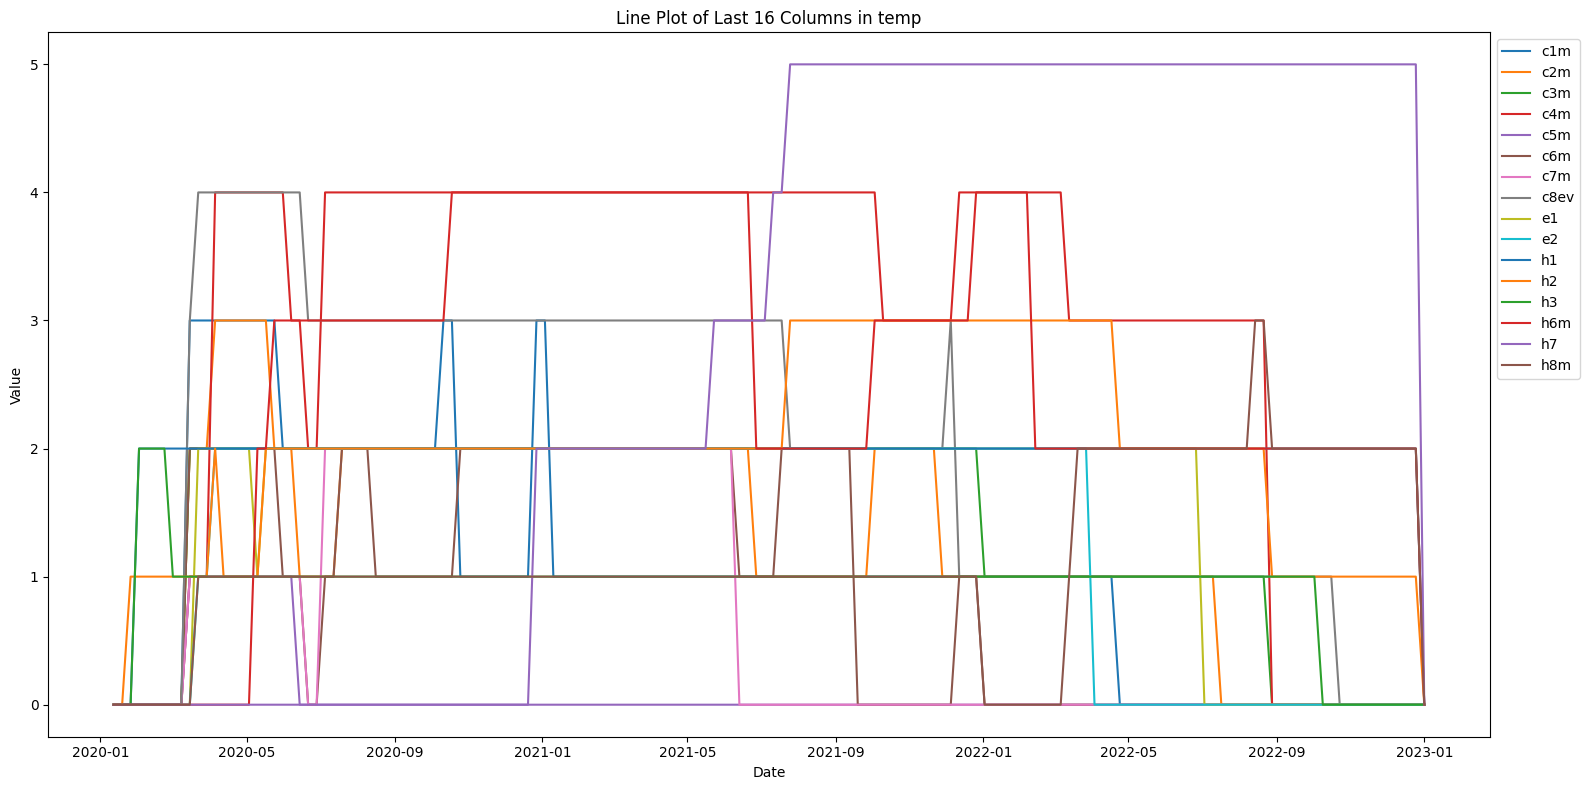

In [69]:
import matplotlib.pyplot as plt
temp = big_df.loc[big_df.location == 'Spain'].copy()
# Select the last 16 columns from temp
cols_to_plot = temp.columns[-16:]

plt.figure(figsize=(16, 8))
for col in cols_to_plot:
    plt.plot(temp['date'], temp[col], label=col)

plt.title('Line Plot of Last 16 Columns in temp')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Vaccination data

In [1]:
import os
os.chdir(r'C:\Users\gsamp\Documents\AAAAAAA\TFG\covid_prediction')

In [2]:
import pandas as pd
training = pd.read_pickle(r'data\training_data\training_datav2_0-weekly.pkl')
training_dates = training.date.unique()
training_countries = training.location.unique()
vaccines_old = pd.read_csv(r'data\vaccinations.csv')

In [3]:
# Define a function to resample data for each country
def resample_country_data(group):
    # Separate numerical and categorical columns
    numerical_cols = group.select_dtypes(include=['number']).columns
    categorical_cols = ['location']  # Add your categorical columns here

    # Resample numerical columns (average for the week)
    weekly_numerical = group[numerical_cols].resample('W-SUN').mean()

    # Resample categorical columns (e.g., take the first value of the week)
    weekly_categorical = group[categorical_cols].resample('W-SUN').first()

    # Combine numerical and categorical data
    weekly_data = pd.concat([weekly_numerical, weekly_categorical], axis=1)
    return weekly_data

In [13]:
df_list = []

for country in training_countries:
    temp = vaccines_old.loc[vaccines_old.location == country][
                                ['location', 'date','total_vaccinations_per_hundred', 
                                 'people_vaccinated_per_hundred',
                                 'people_fully_vaccinated_per_hundred', 
                                 'total_boosters_per_hundred']]
    
    temp['date'] = pd.to_datetime(temp['date'])
    temp = temp.set_index('date')
    temp.index.name = None
    cols_omplir_nan = ['total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
                        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred']
    temp[cols_omplir_nan] = temp[cols_omplir_nan].interpolate(method='time')
    # Group by 'entity' (or 'location') and apply the resampling function
    temp = temp.groupby('location', group_keys=False).apply(resample_country_data)
    temp = temp.fillna(0)

    temp_explore = temp.copy()
    temp_explore['date'] = temp_explore.index

    new_dates_to_add = set(training_dates) - set(temp_explore['date'].unique())

    df_new_dates = pd.DataFrame(0, index=list(new_dates_to_add), columns=temp_explore.columns)

    # Afegeix-los al DataFrame original
    df = pd.concat([temp_explore, df_new_dates])
    df = df.sort_index()

    df = df.loc[df.index.isin(training_dates)].copy()
    df['location'] = [country] * len(df)
    df['date'] = df.index
    
    df_list.append(df)

big_df = pd.concat(df_list, ignore_index=True)
big_df

C:\Users\gsamp\AppData\Local\Temp\ipykernel_5352\235918273.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = temp.groupby('location', group_keys=False).apply(resample_country_data)
C:\Users\gsamp\AppData\Local\Temp\ipykernel_5352\235918273.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = temp.groupby('location', group_keys=False).apply(resample_country_data)
C:\Users\gsamp\AppData\Local

,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,location,date
0,0.000000,0.000000,0.000000,0.00,Algeria,2020-01-12
1,0.000000,0.000000,0.000000,0.00,Algeria,2020-01-19
2,0.000000,0.000000,0.000000,0.00,Algeria,2020-01-26
3,0.000000,0.000000,0.000000,0.00,Algeria,2020-02-02
4,0.000000,0.000000,0.000000,0.00,Algeria,2020-02-09
...,...,...,...,...,...,...
6859,198.548571,80.600000,68.950000,40.08,United States,2022-12-04
6860,199.225714,80.675714,69.007143,40.08,United States,2022-12-11
6861,199.881429,80.751429,69.061429,40.08,United States,2022-12-18
6862,200.415714,80.815714,69.107143,40.08,United States,2022-12-25


In [15]:
big_df.to_pickle(r'data\timeseries_pickles\additional_features\better_vaccine_data.pkl')

In [8]:
training = pd.read_pickle(r'data\training_data\training_datav2_0-weekly.pkl')
training_dates = training.date.unique()

temp_explore = temp_format.copy()
temp_explore['date'] = temp_explore.index

new_dates_to_add = set(training_dates) - set(temp_explore['date'].unique())

df_new_dates = pd.DataFrame(0, index=list(new_dates_to_add), columns=temp_explore.columns)

# Afegeix-los al DataFrame original
df = pd.concat([temp_explore, df_new_dates])
df = df.sort_index()

df = df.loc[df.index.isin(training_dates)].copy()
df

,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,location,date
2020-01-12,0.000000,0.000000,0.000000,0.000000,0,0
2020-01-19,0.000000,0.000000,0.000000,0.000000,0,0
2020-01-26,0.000000,0.000000,0.000000,0.000000,0,0
2020-02-02,0.000000,0.000000,0.000000,0.000000,0,0
2020-02-09,0.000000,0.000000,0.000000,0.000000,0,0
...,...,...,...,...,...,...
2022-12-04,216.566214,86.898929,85.538929,55.249786,Spain,2022-12-04 00:00:00
2022-12-11,217.315750,86.900000,85.542679,55.311286,Spain,2022-12-11 00:00:00
2022-12-18,218.230842,86.902041,85.563750,55.405816,Spain,2022-12-18 00:00:00
2022-12-25,218.794490,86.909388,85.615714,55.462449,Spain,2022-12-25 00:00:00


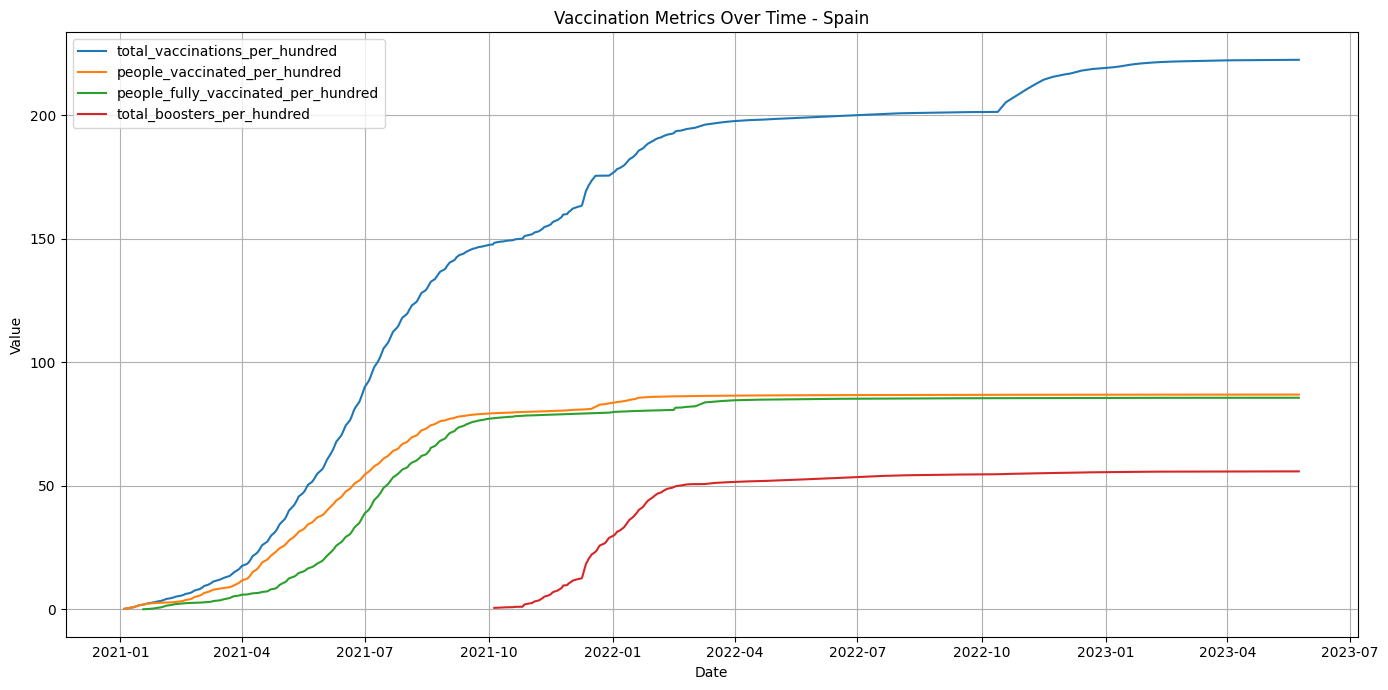

In [9]:
import matplotlib.pyplot as plt

# Select columns to plot (all except the first two: 'location' and index 'date')
cols_to_plot = temp_format.columns[:-1]

plt.figure(figsize=(14, 7))
for col in cols_to_plot:
    plt.plot(temp.index, temp[col], label=col)

plt.title('Vaccination Metrics Over Time - Spain')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df.to_pickle(r'data\timeseries_pickles\additional_features\')

,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,location,date
2021-01-10,0.467857,0.467857,0.000000,0.0,Spain,2021-01-10 00:00:00
2021-01-17,1.378571,1.377143,0.000000,0.0,Spain,2021-01-17 00:00:00
2021-01-24,2.282143,2.189286,0.092143,0.0,Spain,2021-01-24 00:00:00
2021-01-31,3.064286,2.552857,0.512857,0.0,Spain,2021-01-31 00:00:00
2021-02-07,4.052857,2.715714,1.334286,0.0,Spain,2021-02-07 00:00:00
...,...,...,...,...,...,...
2020-08-09,0.000000,0.000000,0.000000,0.0,0,0
2020-12-20,0.000000,0.000000,0.000000,0.0,0,0
2020-02-02,0.000000,0.000000,0.000000,0.0,0,0
2020-05-10,0.000000,0.000000,0.000000,0.0,0,0
